# PHASE 4: IMAGE RETRIEVAL SYSTEM

## Build FAISS Index

In [5]:
PROJECT_ROOT= "/content/drive/MyDrive/image-clustering-retrieval"

In [6]:
!pip install -q faiss-cpu  # Use faiss-gpu if GPU available
import os
import numpy as np
import faiss

print("-" * 60)
print("PHASE 3: IMAGE RETRIEVAL SYSTEM")
print("-" * 60)


class FAISSRetrieval:
    def __init__(self, feature_dim):
        self.feature_dim = feature_dim
        self.index = None
        self.image_paths = None
        self.labels = None

    def build_index(self, features, image_paths, labels, index_type="l2"):
        print("\n🔧 Building FAISS index...")
        print(f"   Features shape: {features.shape}")
        print(f"   Index type: {index_type}")

        self.image_paths = np.array(image_paths)
        self.labels = np.array(labels)

        features = features.astype("float32")

        if index_type == "l2":
            self.index = faiss.IndexFlatL2(self.feature_dim)
        elif index_type == "cosine":
            faiss.normalize_L2(features)
            self.index = faiss.IndexFlatIP(self.feature_dim)
        else:
            raise ValueError("index_type must be 'l2' or 'cosine'")

        self.index.add(features)
        print(f"✅ FAISS index built with {self.index.ntotal} vectors")
        return self

    def save_index(self, save_path):
        os.makedirs(save_path, exist_ok=True)
        faiss.write_index(self.index, f"{save_path}/image_index.faiss")
        np.save(f"{save_path}/index_paths.npy", self.image_paths)
        np.save(f"{save_path}/index_labels.npy", self.labels)
        print(f"✅ FAISS index saved to {save_path}")

    def load_index(self, load_path):
        self.index = faiss.read_index(f"{load_path}/image_index.faiss")
        self.image_paths = np.load(f"{load_path}/index_paths.npy")
        self.labels = np.load(f"{load_path}/index_labels.npy")
        print(f"✅ FAISS index loaded ({self.index.ntotal} vectors)")

    def search(self, query_feature, k=10):
        query_feature = query_feature.reshape(1, -1).astype("float32")
        distances, indices = self.index.search(query_feature, k)

        results = []
        for dist, idx in zip(distances[0], indices[0]):
            similarity = 1 / (1 + dist)
            results.append({
                "index": int(idx),
                "image_path": self.image_paths[idx],
                "label": int(self.labels[idx]),
                "distance": float(dist),
                "similarity": float(similarity)
            })
        return results


def collect_image_paths(dataset_root):
    image_paths = []
    for category in sorted(os.listdir(dataset_root)):
        cat_dir = os.path.join(dataset_root, category)
        if not os.path.isdir(cat_dir):
            continue
        for img in sorted(os.listdir(cat_dir)):
            if img.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(os.path.join(cat_dir, img))
    return image_paths


# --------------------------
# LOAD SAVED ARTIFACTS
# --------------------------

features_normalized = np.load(f"{PROJECT_ROOT}/features/embeddings.npy")
labels = np.load(f"{PROJECT_ROOT}/features/labels.npy")

dataset_path = os.path.join(PROJECT_ROOT, "data/processed/object")
image_paths = collect_image_paths(dataset_path)

assert len(features_normalized) == len(labels) == len(image_paths), \
    "Mismatch between features, labels, and image paths ordering"


# --------------------------
# BUILD & SAVE FAISS INDEX
# --------------------------

print("\n📊 Building FAISS index for retrieval...")

retrieval = FAISSRetrieval(feature_dim=features_normalized.shape[1])
retrieval.build_index(
    features=features_normalized,
    image_paths=image_paths,
    labels=labels,
    index_type="l2"
)

retrieval.save_index(f"{PROJECT_ROOT}/models/faiss_index")

print("\n✅ FAISS index created successfully!")
print(f"   Total indexed images: {retrieval.index.ntotal}")

------------------------------------------------------------
PHASE 3: IMAGE RETRIEVAL SYSTEM
------------------------------------------------------------

📊 Building FAISS index for retrieval...

🔧 Building FAISS index...
   Features shape: (4696, 2048)
   Index type: l2
✅ FAISS index built with 4696 vectors
✅ FAISS index saved to /content/drive/MyDrive/image-clustering-retrieval/models/faiss_index

✅ FAISS index created successfully!
   Total indexed images: 4696


In [7]:
import faiss
import numpy as np
import json
import os
from tqdm import tqdm

# ------------------------------
# CONFIG
# ------------------------------
K_VALUES = [1, 5, 10, 20]          # K for Precision@K

# ------------------------------
# Load features and labels
# ------------------------------
# Assume you already have these numpy arrays
# features: (num_images, feature_dim), labels: (num_images,)
features_path = f"{PROJECT_ROOT}/features/embeddings.npy"
labels_path = f"{PROJECT_ROOT}/features/labels.npy"

features = np.load(features_path)
labels = np.load(labels_path)

# ------------------------------
# Load FAISS index
# ------------------------------
index_path = f"{PROJECT_ROOT}/models/faiss_index/image_index.faiss"
index = faiss.read_index(index_path)

# ------------------------------
# Compute Precision@K
# ------------------------------
precision_at_k = {}

for K in K_VALUES:
    correct_counts = 0
    for i in tqdm(range(len(features)), desc=f"Computing Precision@{K}"):
        query_vec = features[i].reshape(1, -1).astype('float32')
        _, idxs = index.search(query_vec, K+1)  # +1 because the query itself is retrieved
        retrieved_labels = labels[idxs[0][1:]]  # skip the first (self-match)
        if labels[i] in retrieved_labels:
            correct_counts += 1
    precision_at_k[f"precision@{K}"] = correct_counts / len(features)

# ------------------------------
# Save retrieval metrics
# ------------------------------
retrieval_metrics_path = f"{PROJECT_ROOT}/results/retrieval/retrieval_metrics.json"
os.makedirs(os.path.dirname(retrieval_metrics_path), exist_ok=True)
with open(retrieval_metrics_path, 'w') as f:
    json.dump(precision_at_k, f, indent=2)

print("✅ Retrieval metrics (Precision@K) computed and saved!")
print(precision_at_k)

Computing Precision@20: 100%|██████████| 4696/4696 [00:21<00:00, 221.20it/s]


✅ Retrieval metrics (Precision@K) computed and saved!
{'precision@1': 0.8805366269165247, 'precision@5': 0.9848807495741057, 'precision@10': 0.9931856899488927, 'precision@20': 0.9963798977853492}


# Testing on Unseen Images

✅ FAISS index loaded (4696 vectors)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 85.8MB/s]


Saving cs.jfif to cs.jfif


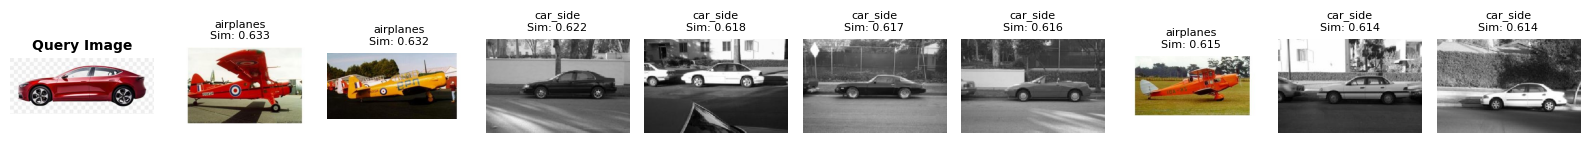

In [9]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from google.colab import files
import faiss

# Load categories (NOT from dataset object)
dataset_path = os.path.join(PROJECT_ROOT, "data/processed/object")
categories = sorted([
    d for d in os.listdir(dataset_path)
    if os.path.isdir(os.path.join(dataset_path, d))
])
# 2️⃣ Load FAISS index (already built)
retrieval = FAISSRetrieval(feature_dim=2048)
retrieval.load_index(f"{PROJECT_ROOT}/models/faiss_index")
# 3️⃣ Load feature extractor (same model used before)
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
extractor = nn.Sequential(*list(model.children())[:-1])
extractor.to(device)
extractor.eval()
# 4️⃣ Define transforms (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
# 5️⃣ Visualization function (NO dataset dependency)
def visualize_unseen_query(img, results, categories):
    fig = plt.figure(figsize=(16, 4))

    ax = plt.subplot(1, len(results) + 1, 1)
    ax.imshow(img)
    ax.set_title("Query Image", fontsize=10, fontweight="bold")
    ax.axis("off")

    for i, res in enumerate(results):
        ax = plt.subplot(1, len(results) + 1, i + 2)
        retrieved_img = Image.open(res["image_path"]).convert("RGB")
        ax.imshow(retrieved_img)

        cat_name = categories[res["label"]]
        ax.set_title(f"{cat_name}\nSim: {res['similarity']:.3f}", fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.show()
# 6️⃣ Upload unseen image
uploaded = files.upload()
uploaded_path = list(uploaded.keys())[0]
img = Image.open(uploaded_path).convert("RGB")

# 7️⃣ Extract feature for query image
with torch.no_grad():
    img_tensor = transform(img).unsqueeze(0).to(device)
    feature = extractor(img_tensor)
    feature = feature.view(feature.size(0), -1).cpu().numpy()
    feature = feature / np.linalg.norm(feature)

# 8️⃣ FAISS search
results = retrieval.search(feature, k=9)

# 9️⃣ Visualize results
visualize_unseen_query(img, results, categories)

# Train Classifier 1 (Random Forest classifier)

In [12]:
  from sklearn.model_selection import train_test_split
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.metrics import accuracy_score
  from sklearn.preprocessing import StandardScaler
  from sklearn.decomposition import PCA
  import pickle
  import json
  from datetime import datetime

  print("-"*60)
  print("PHASE 4: CLASSIFICATION")
  print("-"*60)

  # --- Step 1: Create train/validation split ---
  X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
      features_normalized,
      labels,
      test_size=0.2,
      random_state=42,
      stratify=labels
  )
  print(f"Train samples: {len(X_train_split)}, Validation samples: {len(X_val_split)}")

  # --- Step 2: Optional PCA ---
  use_pca = True
  if use_pca and X_train_split.shape[1] > 512:
      print("Applying PCA to reduce feature dimensions to 512...")
      pca_model = PCA(n_components=512, random_state=42)
      X_train_proc = pca_model.fit_transform(X_train_split)
      X_val_proc = pca_model.transform(X_val_split)

      # Save PCA
      os.makedirs(f'{PROJECT_ROOT}/models/classifier', exist_ok=True)
      with open(f'{PROJECT_ROOT}/models/classifier/pca.pkl', 'wb') as f:
          pickle.dump(pca_model, f)
  else:
      X_train_proc, X_val_proc = X_train_split, X_val_split
      pca_model = None

  # --- Step 3: Standardize features ---
  scaler_model = StandardScaler()
  X_train_proc = scaler_model.fit_transform(X_train_proc)
  X_val_proc = scaler_model.transform(X_val_proc)

  # Save scaler
  with open(f'{PROJECT_ROOT}/models/classifier/scaler.pkl', 'wb') as f:
      pickle.dump(scaler_model, f)

  # --- Step 4: Train classifier ---
  print("\nTraining Random Forest classifier...")
  classifier = RandomForestClassifier(
      n_estimators=100,
      max_depth=20,
      random_state=42,
      n_jobs=-1,
      verbose=1
  )
  classifier.fit(X_train_proc, y_train_split)

  # Save classifier
  with open(f'{PROJECT_ROOT}/models/classifier/random_forest.pkl', 'wb') as f:
      pickle.dump(classifier, f)

  # --- Step 5: Evaluate ---
  train_pred = classifier.predict(X_train_proc)
  val_pred = classifier.predict(X_val_proc)
  train_acc = accuracy_score(y_train_split, train_pred)
  val_acc = accuracy_score(y_val_split, val_pred)

  print(f"\nTraining Accuracy:   {train_acc:.4f}")
  print(f"Validation Accuracy: {val_acc:.4f}")

  # Save results
  results = {
      'classifier_type': 'random_forest',
      'train_accuracy': float(train_acc),
      'validation_accuracy': float(val_acc),
      'use_pca': use_pca,
      'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
  }

  with open(f'{PROJECT_ROOT}/models/classifier/classification_results.json', 'w') as f:
      json.dump(results, f, indent=2)

  print("✅ Classifier trained and saved!")

------------------------------------------------------------
PHASE 4: CLASSIFICATION
------------------------------------------------------------
Train samples: 3756, Validation samples: 940
Applying PCA to reduce feature dimensions to 512...

Training Random Forest classifier...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.



Training Accuracy:   1.0000
Validation Accuracy: 0.9074
✅ Classifier trained and saved!


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


#  Train Classifier 2 (SVM classifier)

In [16]:
from sklearn.svm import SVC
import json
import pickle
from datetime import datetime
from sklearn.metrics import accuracy_score
import os

print("-"*60)
print("PHASE 4: CLASSIFICATION (SVM)")
print("-"*60)

# --- Step 1: Train SVM ---
print("\nTraining SVM (RBF kernel)...")

svm_classifier = SVC(
    kernel='rbf',
    C=10,                  # strong but not crazy
    gamma='scale',         # adaptive, safe default
    probability=False,     # faster, you don't need probs
    class_weight='balanced',  # IMPORTANT for Caltech-101
    verbose=True
)

svm_classifier.fit(X_train_proc, y_train_split)

# --- Step 2: Evaluate ---
train_pred_svm = svm_classifier.predict(X_train_proc)
val_pred_svm = svm_classifier.predict(X_val_proc)

train_acc_svm = accuracy_score(y_train_split, train_pred_svm)
val_acc_svm = accuracy_score(y_val_split, val_pred_svm)

print(f"\nSVM Training Accuracy:   {train_acc_svm:.4f}")
print(f"SVM Validation Accuracy: {val_acc_svm:.4f}")

# --- Step 3: Save model ---
os.makedirs(f'{PROJECT_ROOT}/models/classifier', exist_ok=True)

with open(f'{PROJECT_ROOT}/models/classifier/svm_rbf.pkl', 'wb') as f:
    pickle.dump(svm_classifier, f)

# --- Step 4: Save results ---
svm_results = {
    'classifier_type': 'svm_rbf',
    'kernel': 'rbf',
    'C': 10,
    'gamma': 'scale',
    'train_accuracy': float(train_acc_svm),
    'validation_accuracy': float(val_acc_svm),
    'use_pca': True,
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(f'{PROJECT_ROOT}/models/classifier/classification_results_svm.json', 'w') as f:
    json.dump(svm_results, f, indent=2)

print("✅ SVM classifier trained and saved!")

------------------------------------------------------------
PHASE 4: CLASSIFICATION (SVM)
------------------------------------------------------------

Training SVM (RBF kernel)...
[LibSVM]
SVM Training Accuracy:   0.9995
SVM Validation Accuracy: 0.9149
✅ SVM classifier trained and saved!


# SVM vs RF Accuracy Comparison Plot

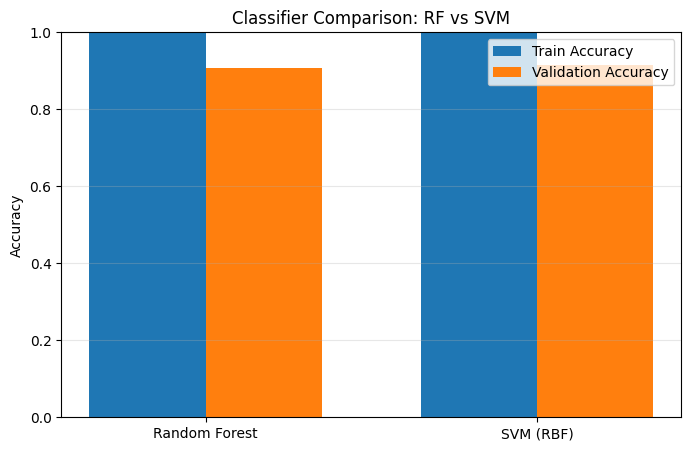


Random Forest: 
Train accuracy: 100.0 Validation accuracy: 90.74468085106383
--------------------------------------------------
SVM: 
Train accuracy: 99.94675186368477 Validation accuracy: 91.48936170212765


In [17]:
# Paths to saved results
rf_path = f'{PROJECT_ROOT}/models/classifier/classification_results.json'
svm_path = f'{PROJECT_ROOT}/models/classifier/classification_results_svm.json'

# Load results
with open(rf_path) as f:
    rf_results = json.load(f)

with open(svm_path) as f:
    svm_results = json.load(f)

models = ['Random Forest', 'SVM (RBF)']
train_acc = [
    rf_results['train_accuracy'],
    svm_results['train_accuracy']
]
val_acc = [
    rf_results['validation_accuracy'],
    svm_results['validation_accuracy']
]

# Plot
x = range(len(models))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, train_acc, width, label='Train Accuracy')
plt.bar([i + width for i in x], val_acc, width, label='Validation Accuracy')

plt.xticks([i + width/2 for i in x], models)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Classifier Comparison: RF vs SVM')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Save
os.makedirs(f'{PROJECT_ROOT}/results/classification', exist_ok=True)
plt.savefig(f'{PROJECT_ROOT}/results/classification/rf_vs_svm_accuracy.png',
            dpi=150, bbox_inches='tight')

plt.show()
print("\nRandom Forest: \nTrain accuracy:",rf_results['train_accuracy']*100, "Validation accuracy:",rf_results['validation_accuracy']*100)
print("-"*50)
print("SVM: \nTrain accuracy:",svm_results['train_accuracy']*100, "Validation accuracy:",svm_results['validation_accuracy']*100)

# Confusion Matrix

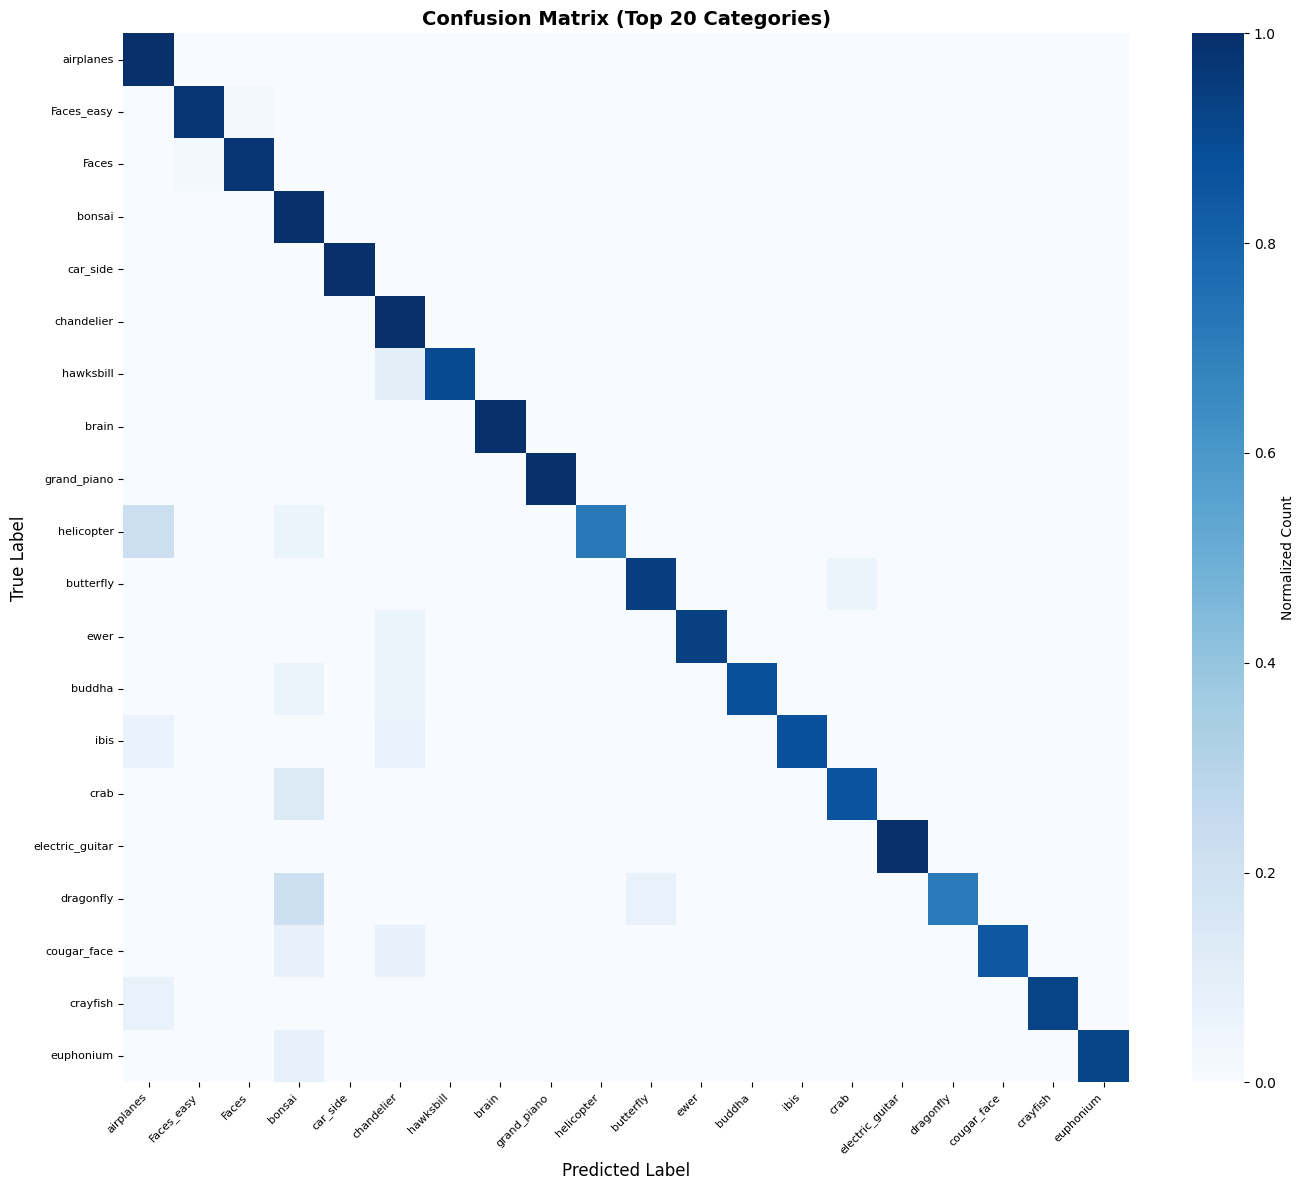

✅ Confusion matrix saved!


In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --------------------------
# LOAD CATEGORIES FROM DISK
# --------------------------
dataset_path = os.path.join(PROJECT_ROOT, "data/processed/object")
categories = sorted([
    d for d in os.listdir(dataset_path)
    if os.path.isdir(os.path.join(dataset_path, d))
])

# --------------------------
# CONFUSION MATRIX FUNCTION
# --------------------------
def plot_confusion_matrix(y_true, y_pred, categories, top_n=20):
    unique, counts = np.unique(y_true, return_counts=True)
    top_indices = np.argsort(counts)[::-1][:top_n]

    mask = np.isin(y_true, top_indices)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_indices)
    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    category_names = [categories[i] for i in top_indices]

    plt.figure(figsize=(14, 12))
    sns.heatmap(
        cm_norm,
        cmap="Blues",
        xticklabels=category_names,
        yticklabels=category_names,
        cbar_kws={"label": "Normalized Count"}
    )

    plt.title(f"Confusion Matrix (Top {top_n} Categories)", fontsize=14, fontweight="bold")
    plt.ylabel("True Label", fontsize=12)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()

    os.makedirs(f"{PROJECT_ROOT}/results/classification", exist_ok=True)
    plt.savefig(
        f"{PROJECT_ROOT}/results/classification/confusion_matrix.png",
        dpi=150,
        bbox_inches="tight"
    )
    plt.show()

    print("✅ Confusion matrix saved!")

# --------------------------
# RUN
# --------------------------
plot_confusion_matrix(
    y_val_split,
    val_pred_svm,
    categories,
    top_n=20
)

# PHASE 5: FINAL EVALUATION
## Generate Comprehensive Report

In [22]:
print("-"*60)
print("PHASE 5: FINAL EVALUATION")
print("-"*60)

def generate_final_report():
    """Generate comprehensive report combining clustering, retrieval, classification"""
    print("\n📝 Generating final report...")

    # --- Load clustering metrics (Hierarchical) ---
    clustering_metrics_path = f'{PROJECT_ROOT}/models/clustering/hir_metrics_k50.json' # Corrected path
    if os.path.exists(clustering_metrics_path):
        with open(clustering_metrics_path) as f:
            clustering_metrics = json.load(f)
    else:
        # Fallback if the file still doesn't exist, though it should now
        print(f"Warning: Clustering metrics file not found at {clustering_metrics_path}. Using default values.")
        clustering_metrics = {
            'k': 50, # Changed n_clusters to k to match saved metric key
            'silhouette_score': 0,
            'davies_bouldin_score': 0,
            'cluster_sizes': {}
        }

    # --- Load retrieval metrics ---
    retrieval_metrics_path = f'{PROJECT_ROOT}/results/retrieval/retrieval_metrics.json'
    if os.path.exists(retrieval_metrics_path):
        with open(retrieval_metrics_path) as f:
            retrieval_metrics = json.load(f)
    else:
        retrieval_metrics = {}

    # --- Load classification metrics (SVM) ---
    classification_results_path = f'{PROJECT_ROOT}/models/classifier/classification_results_svm.json'
    if os.path.exists(classification_results_path):
        with open(classification_results_path) as f:
            classification_results = json.load(f)
    else:
        classification_results = {
            'classifier_type': 'SVM',
            'train_accuracy': 0,
            'validation_accuracy': 0
        }

    # --- Load dataset metadata ---
    dataset_metadata_path = f'{PROJECT_ROOT}/configs/dataset_metadata.json'
    if os.path.exists(dataset_metadata_path):
        with open(dataset_metadata_path) as f:
            dataset_info = json.load(f)
    else:
        dataset_info = {
            'num_categories': len(full_dataset.categories),
            'num_images': len(full_dataset.image_paths),
            'categories': full_dataset.categories
        }

    # --- Compose report ---
    report = {
        'dataset': dataset_info,
        'feature_extraction': {
            'model': 'ResNet-50',
            'feature_dim': 2048,
            'preprocessing': 'L2 normalization'
        },
        'clustering': clustering_metrics,
        'retrieval': retrieval_metrics,
        'classification': classification_results,
        'generated_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }

    # --- Save report ---
    save_path = f'{PROJECT_ROOT}/results/final_report.json'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, 'w') as f:
        json.dump(report, f, indent=2)

    # --- Print summary ---
    print("\n" + "="*60)
    print("FINAL SYSTEM SUMMARY")
    print("="*60)
    print(f"\n📊 Dataset: Caltech-101")
    print(f"   Total categories: {dataset_info['num_categories']}")
    print(f"   Total images: {dataset_info['num_images']}")
    print(f"\n🔧 Feature Extractor: ResNet-50 (2048-dim)")
    print(f"\n🎯 Clustering (Hierarchical):")
    print(f"   • Number of clusters: {clustering_metrics.get('k', 'N/A')}") # Changed n_clusters to k
    print(f"   • Silhouette Score: {clustering_metrics.get('silhouette_score', 0):.4f}")
    print(f"   • Davies-Bouldin: {clustering_metrics.get('davies_bouldin_score', 0):.4f}")
    print(f"\n🔍 Retrieval:")
    print(f"   • Precision@10: {retrieval_metrics.get('precision@10', 'N/A')}")
    print(f"   • Index size: {getattr(retrieval.index, 'ntotal', 'N/A')} vectors")
    print(f"\n🎓 Classification (SVM):")
    print(f"   • Model: {classification_results.get('classifier_type', 'SVM')}")
    print(f"   • Training Accuracy: {classification_results.get('train_accuracy', 0):.4f}")
    print(f"   • Validation Accuracy: {classification_results.get('validation_accuracy', 0):.4f}")
    print("="*60)

    print("\n✅ Final report generated!")
    return report

# Run
final_report = generate_final_report()

------------------------------------------------------------
PHASE 5: FINAL EVALUATION
------------------------------------------------------------

📝 Generating final report...

FINAL SYSTEM SUMMARY

📊 Dataset: Caltech-101
   Total categories: 50
   Total images: 4696

🔧 Feature Extractor: ResNet-50 (2048-dim)

🎯 Clustering (Hierarchical):
   • Number of clusters: 50
   • Silhouette Score: 0.1819
   • Davies-Bouldin: 2.1500

🔍 Retrieval:
   • Precision@10: 0.9931856899488927
   • Index size: 4696 vectors

🎓 Classification (SVM):
   • Model: svm_rbf
   • Training Accuracy: 0.9995
   • Validation Accuracy: 0.9149

✅ Final report generated!


# Performance Summary Visualization

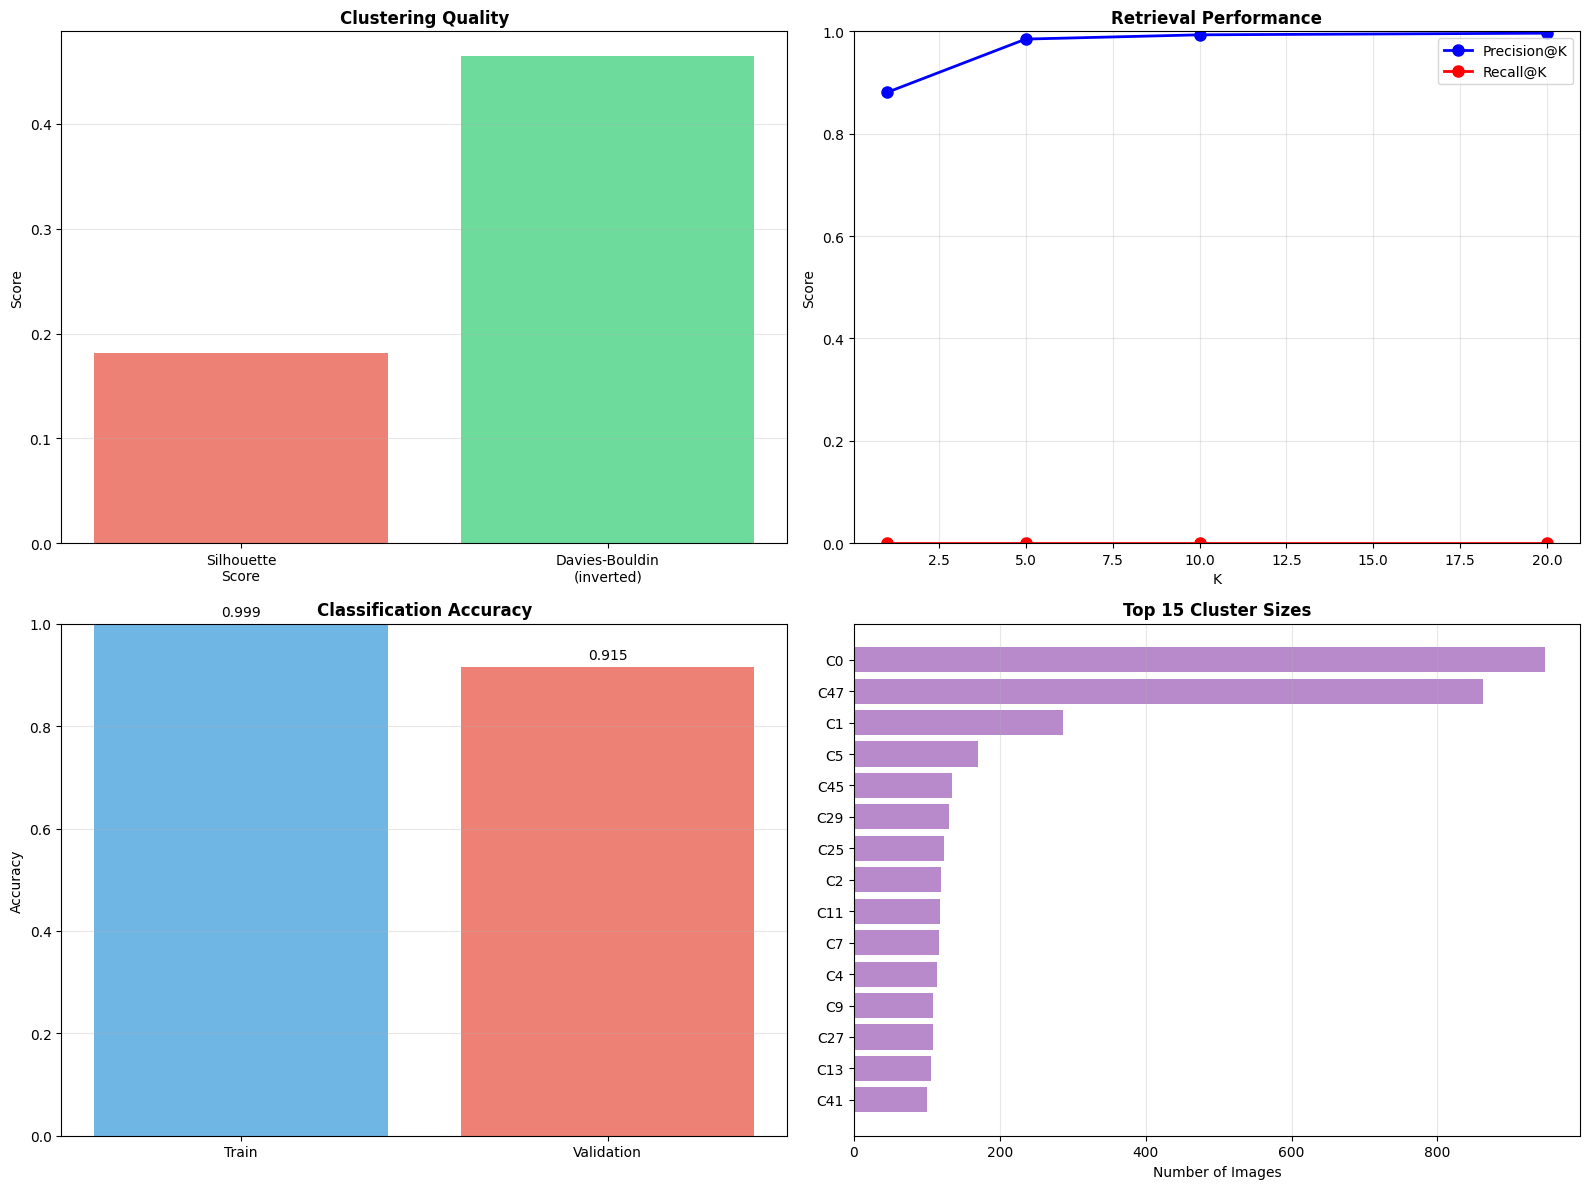

✅ Performance summary saved!


In [23]:
def plot_performance_summary(report):
    """Create an enhanced performance summary visualization (without entropy plot)"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # 1️⃣ Clustering Quality
    ax = axes[0, 0]
    metrics_values = [
        report['clustering'].get('silhouette_score', 0),
        1 / report['clustering'].get('davies_bouldin_score', 1e-5)  # invert DB
    ]
    metrics_names = ['Silhouette\nScore', 'Davies-Bouldin\n(inverted)']
    colors = ['#2ecc71' if v > 0.3 else '#e74c3c' for v in metrics_values]
    ax.bar(metrics_names, metrics_values, color=colors, alpha=0.7)
    ax.set_ylabel('Score')
    ax.set_title('Clustering Quality', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    # 2️⃣ Retrieval Performance
    ax = axes[0, 1]
    k_values = [1, 5, 10, 20]
    precisions = [report['retrieval'].get(f'precision@{k}', 0) for k in k_values]
    recalls = [report['retrieval'].get(f'recall@{k}', 0) for k in k_values]
    ax.plot(k_values, precisions, 'bo-', linewidth=2, markersize=8, label='Precision@K')
    ax.plot(k_values, recalls, 'ro-', linewidth=2, markersize=8, label='Recall@K')
    ax.set_xlabel('K')
    ax.set_ylabel('Score')
    ax.set_title('Retrieval Performance', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    ax.legend()

    # 3️⃣ Classification Accuracy
    ax = axes[1, 0]
    accuracies = [
        report['classification'].get('train_accuracy', 0),
        report['classification'].get('validation_accuracy', 0)
    ]
    labels = ['Train', 'Validation']
    colors_acc = ['#3498db', '#e74c3c']
    bars = ax.bar(labels, accuracies, color=colors_acc, alpha=0.7)
    ax.set_ylabel('Accuracy')
    ax.set_title('Classification Accuracy', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    # 4️⃣ Top Cluster Sizes
    ax = axes[1, 1]
    cluster_sizes = report['clustering'].get('cluster_sizes', {})
    top_clusters = sorted(cluster_sizes.items(), key=lambda x: x[1], reverse=True)[:15]
    cluster_ids = [f"C{k}" for k, _ in top_clusters]
    sizes = [v for _, v in top_clusters]
    ax.barh(cluster_ids[::-1], sizes[::-1], color='#9b59b6', alpha=0.7)
    ax.set_xlabel('Number of Images')
    ax.set_title('Top 15 Cluster Sizes', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    os.makedirs(f'{PROJECT_ROOT}/results', exist_ok=True)
    plt.savefig(f'{PROJECT_ROOT}/results/performance_summary.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✅ Performance summary saved!")

# Example usage
plot_performance_summary(final_report)